In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv(r'D:\Stock_trend_project\data\raw\train.csv')

sns.set()

unique_tickers = train['Ticker'].dropna().unique()
n_tickers_sample = 1000
sampled_tickers = np.random.choice(unique_tickers,
                                   size=min(n_tickers_sample, len(unique_tickers)),
                                   replace=False)

train_ticker_sample = train[train['Ticker'].isin(sampled_tickers)].copy()

train_ticker_sample['Date'] = pd.to_datetime(train_ticker_sample['Date'])

train_ticker_sample = train_ticker_sample.sort_values(['Ticker', 'Date'])

def sample_per_ticker(df, n_per_ticker=500):

    idx = np.linspace(0, len(df) - 1, num=min(n_per_ticker, len(df))).astype(int)
    return df.iloc[idx]

n_per_ticker = 500


eda_sample = (
    train_ticker_sample
    .groupby('Ticker', group_keys=True)
    .apply(sample_per_ticker, n_per_ticker=n_per_ticker, include_groups=False)
)
eda_sample = eda_sample.reset_index(level=0).rename(columns={"level_0": "Ticker"})


## Computing daily returns per stock

This code sorts the data by company and date, then computes the daily percentage return for each company as (Closet−Closet−1)/Closet−1(Closet−Closet−1)/Closet−1, drops the first day of each company (where the return is NaN), and finally shows a preview of the resulting DailyReturn alongside the original Close prices.

In [7]:

returns_df = train.sort_values(["Ticker", "Date"]).copy()

# Return_t = (Close_t - Close_{t-1}) / Close_{t-1}
returns_df["DailyReturn"] = (
    returns_df
    .groupby("Ticker")["Close"]
    .pct_change()
)

# 3) حذف أول صف لكل شركة (عائده NaN)
returns_df = returns_df.dropna(subset=["DailyReturn"])

returns_df[["Ticker", "Date", "Close", "DailyReturn"]].head(10)


,Ticker,Date,Close,DailyReturn
25,ticker_1,1962-01-03,0.261788,0.000000
49,ticker_1,1962-01-04,0.260980,-0.003086
76,ticker_1,1962-01-05,0.255324,-0.021673
97,ticker_1,1962-01-08,0.256536,0.004747
113,ticker_1,1962-01-09,0.256132,-0.001575
129,ticker_1,1962-01-10,0.255324,-0.003155
144,ticker_1,1962-01-11,0.256536,0.004747
171,ticker_1,1962-01-12,0.258556,0.007874
198,ticker_1,1962-01-15,0.259364,0.003125
219,ticker_1,1962-01-16,0.255728,-0.014018


## Inspecting daily return behaviour

This block summarizes the DailyReturn feature by: reporting basic descriptive statistics, measuring the fraction of days with positive vs negative returns, counting extreme daily moves larger than 20% in absolute value, counting days with exactly zero return, and listing the top 10 most positive and the top 10 most negative daily returns to inspect the most extreme cases.

In [6]:

returns_df["DailyReturn"].describe()

(returns_df["DailyReturn"] > 0).mean(), (returns_df["DailyReturn"] < 0).mean()

(returns_df["DailyReturn"].abs() > 0.2).sum()

returns_df[returns_df["DailyReturn"] == 0].shape

returns_df.nlargest(10, "DailyReturn")
returns_df.nsmallest(10, "DailyReturn")


,Ticker,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,DailyReturn
18529921,ticker_4051,2022-09-15,0.170000,0.170000,0.170000,0.170000,0.0,0.0,0.0,-0.980000
11406743,ticker_2489,2014-09-03,7.500000,7.500000,7.500000,7.500000,1.0,0.0,0.0,-0.975000
5173867,ticker_504,2003-03-26,0.383368,0.447262,0.319473,0.351421,22074378.0,0.0,0.0,-0.971867
19417766,ticker_4274,2023-06-08,0.208000,0.215000,0.171000,0.185000,2394600.0,0.0,0.0,-0.962090
10856590,ticker_2188,2013-11-08,3.800000,5.500000,3.800000,5.400000,1480.0,0.0,0.0,-0.946054
2853648,ticker_948,1996-07-30,4.760000,4.760000,4.760000,4.760000,95.0,0.0,0.0,-0.933333
20695655,ticker_4361,2024-06-17,2.410000,2.510000,1.500000,1.650000,25207800.0,0.0,0.0,-0.932981
8205243,ticker_2188,2009-06-22,2.000000,2.000000,1.000000,1.200000,3500.0,0.0,0.0,-0.929412
1267459,ticker_349,1988-12-05,2.169958,2.789946,2.169958,2.169958,15162.0,0.0,0.0,-0.927083
20892410,ticker_4822,2024-08-13,3.350000,4.420000,2.650000,3.200000,2416000.0,0.0,0.0,-0.920988


## Daily return distribution summary

This block:

    Uses DailyReturn.describe() and abs().nlargest(10) to quantify typical returns and list the most extreme daily moves.

    Clips returns to [−0.3,0.3][−0.3,0.3] and plots a histogram to visualize the main body of the distribution without distortion from outliers.

    Computes the fraction of zero and near‑zero returns to show how often prices barely move.

    Reports skewness and kurtosis to highlight that the return distribution is asymmetric with heavy tails, indicating the presence of impactful outliers.


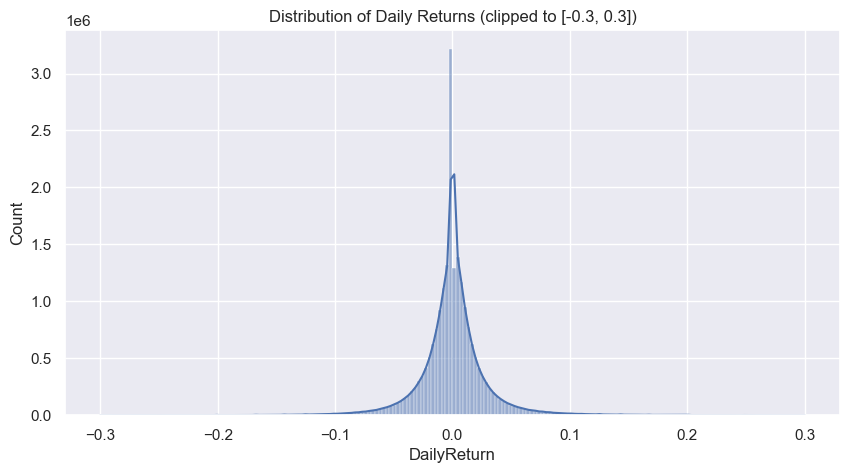

In [11]:
returns_df["DailyReturn"].describe()
returns_df["DailyReturn"].abs().nlargest(10)

returns_main = returns_df[returns_df["DailyReturn"].between(-0.3, 0.3)]

plt.figure(figsize=(10, 5))
sns.histplot(
    data=returns_main,
    x="DailyReturn",
    bins=200,
    kde=True,
)
plt.title("Distribution of Daily Returns (clipped to [-0.3, 0.3])")
plt.xlabel("DailyReturn")
plt.ylabel("Count")
plt.show()



In [12]:

print(returns_df["DailyReturn"].describe())

zero_frac = (returns_df["DailyReturn"] == 0).mean()
print("Fraction zeros:", zero_frac)

small_frac = (returns_df["DailyReturn"].abs() < 1e-3).mean()
print("Fraction |r|<0.001:", small_frac)

print(returns_df["DailyReturn"].abs().nlargest(10))

print("skew:", returns_df["DailyReturn"].skew())
print("kurt:", returns_df["DailyReturn"].kurtosis())


count    2.102852e+07
mean     7.490496e-04
std      7.648859e-02
min     -9.800000e-01
25%     -1.043082e-02
50%      0.000000e+00
75%      1.063817e-02
max      2.573333e+02
Name: DailyReturn, dtype: float64
Fraction zeros: 0.09393166100784449
Fraction |r|<0.001: 0.12530904454435743
16488603    257.333339
8468028     116.499856
16107287     53.000000
18539809     41.647058
19195320     39.701756
11411921     38.600000
17143871     33.889999
2634342      31.000000
11727057     27.947369
15527096     19.772948
Name: DailyReturn, dtype: float64
skew: 2032.4311999627105
kurt: 6375064.188482595
